In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from holisticai.explainability import Explainer
from holisticai.efficacy.metrics import regression_efficacy_metrics

In [3]:
dataset = load_diabetes() # load dataset

X = dataset.data # features
y = dataset.target # target 
feature_names = dataset.feature_names # feature names

X = pd.DataFrame(X, columns=feature_names) # convert to dataframe

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'bp'}>, <Axes: title={'center': 's1'}>,
        <Axes: title={'center': 's2'}>],
       [<Axes: title={'center': 's3'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's5'}>],
       [<Axes: title={'center': 's6'}>, <Axes: >, <Axes: >]], dtype=object)

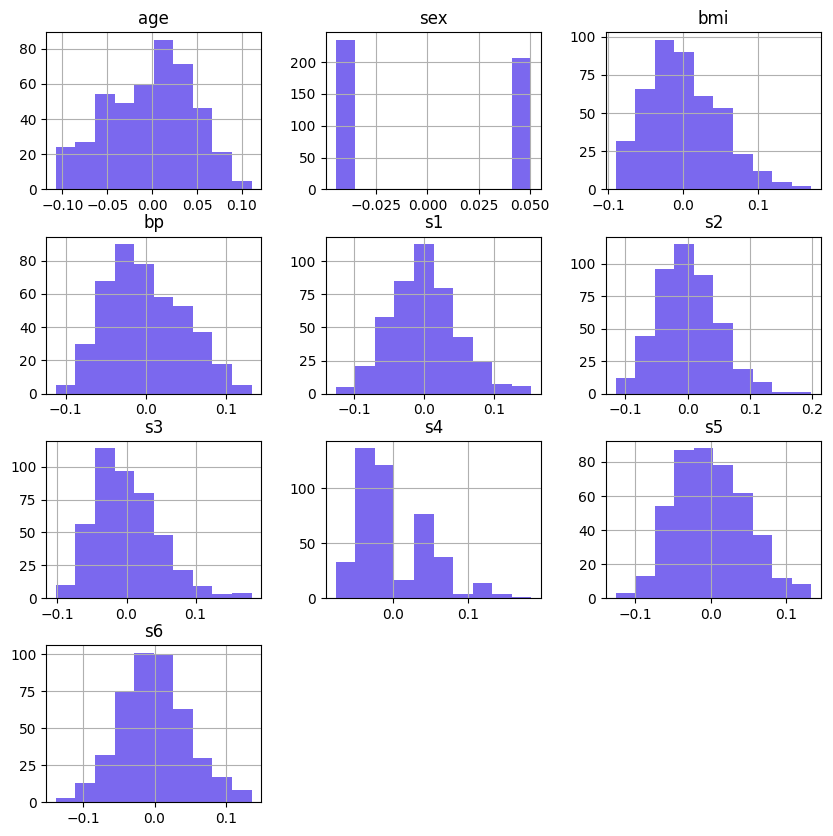

In [4]:
X.hist(bins=10, figsize=(10, 10), color = 'mediumslateblue')

<Axes: >

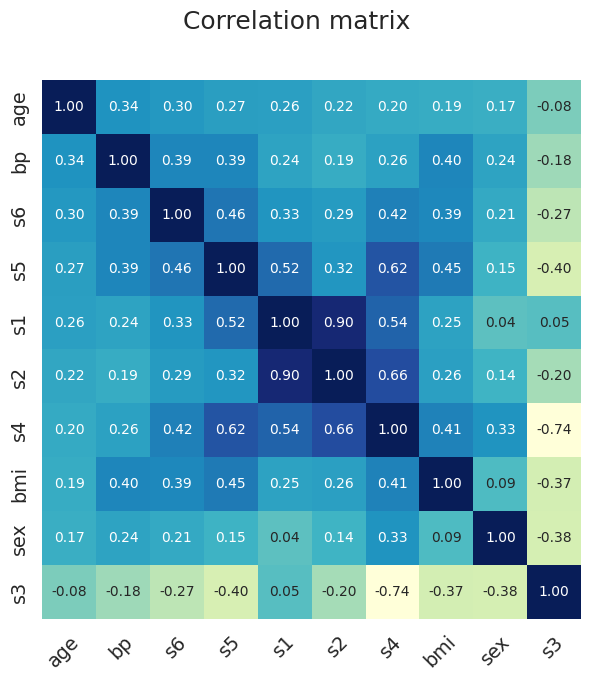

In [5]:
from holisticai.bias.plots import correlation_matrix_plot

correlation_matrix_plot(X, target_feature='age', size = (12,7))

In [6]:
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
seed = np.random.seed(42) # set seed for reproducibility
# simple preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed) # train test split


model = GradientBoostingRegressor() # instantiate model
model.fit(X_train, y_train) # fit model

y_pred = model.predict(X_test) # compute predictions

# compute efficacy metrics
regression_efficacy_metrics(y_test, y_pred)

,Value,Reference
Metric,,
RMSE,53.952020,0
MAE,44.638564,0
MAPE,0.399881,0
Max Error,131.736157,0
SMAPE,0.164915,0


# Global Explainability Metrics (based on Permutation Feature Importance)

In [7]:
# permutation feature importance
permutation_explainer = Explainer(based_on='feature_importance',
                      strategy_type='permutation',
                      model_type='regression',
                      model = model, 
                      x = X, 
                      y = y)

In [8]:
permutation_explainer.metrics()

,Value,Reference
Fourth Fifths,0.400000,0
Importance Spread Divergence,0.460785,-
Importance Spread Ratio,0.799884,0
Global Overlap Score,0.306776,1
Global Range Overlap Score,0.752946,1
Global Similarity Score,0.840495,1
Global Explainability Ease Score,0.750000,1


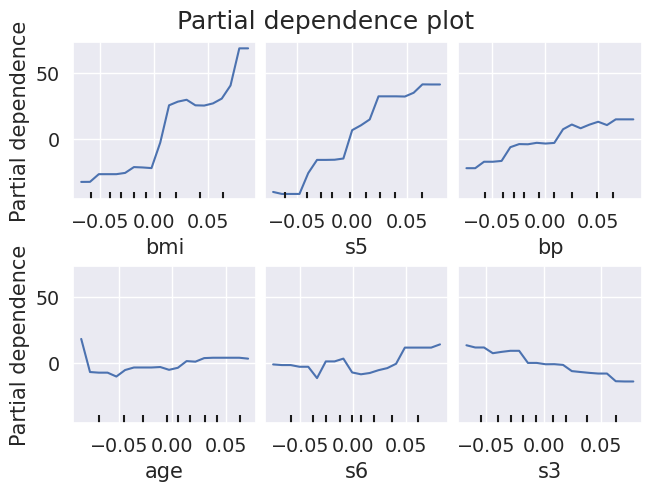

In [9]:
permutation_explainer.partial_dependence_plot()

In [10]:
permutation_explainer.metrics(detailed=True)

,Value,Reference
Fourth Fifths,0.400000,0
Importance Spread Divergence,0.460785,-
Importance Spread Ratio,0.799884,0
Global Overlap Score [Q0-Q1],0.031111,1
Global Overlap Score [Q1-Q2],0.485794,1
Global Overlap Score [Q2-Q3],0.047897,1
Global Overlap Score [Q3-Q4],0.662302,1
Global Range Overlap Score [Q0-Q1],0.704048,1
Global Range Overlap Score [Q1-Q2],0.799484,1
Global Range Overlap Score [Q2-Q3],0.607817,1


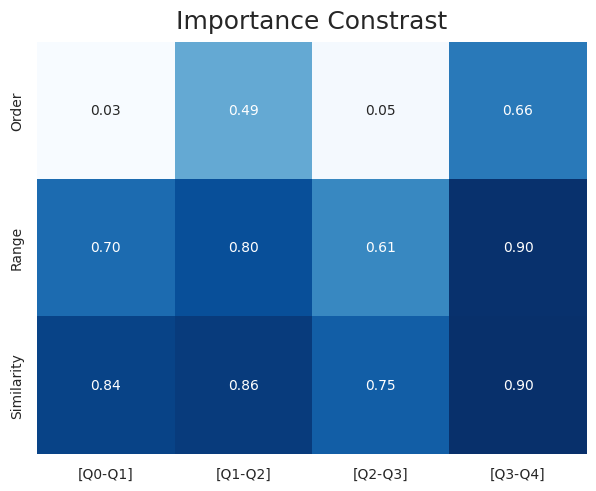

In [11]:
# Contrast Whole Importance vs. Group Importance
# -> Order -> mean positions
# -> Range -> match range of position 
# -> Similarity -> compute similarity
# -> e.g. we can see that Q0-Q1 and Q2-Q3 strong changes in their position but their importance weights maintains a high similarity with the whole model.
# -> e.g. we can see that Q1-Q2 and Q3-Q4 small changes in their position and their importance weights maintains a high similarity with the whole model.
permutation_explainer.contrast_visualization(show_connections=False)
# TODO separate show connections sin a second matrix

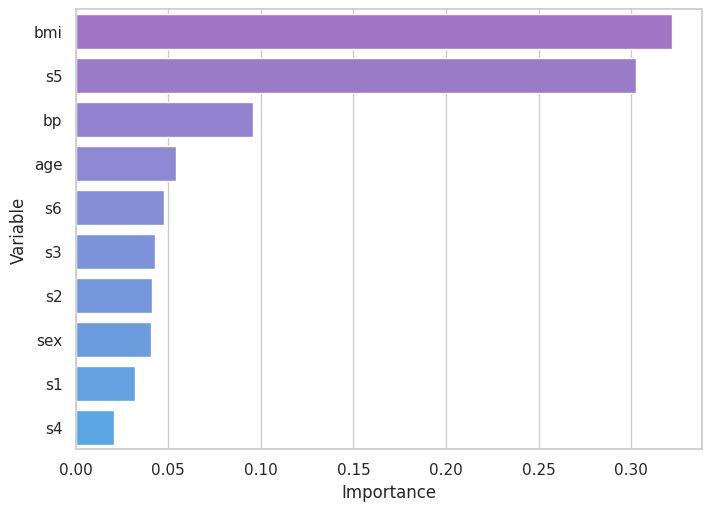

In [12]:
permutation_explainer.bar_plot(max_display=10)

In [13]:
permutation_explainer.feature_importance_table(sorted_by='Global', top_n=5)

,Global Importance,[Q0-Q1] Importance,[Q1-Q2] Importance,[Q2-Q3] Importance,[Q3-Q4] Importance
Variable,,,,,
bmi,0.321886,0.122267,0.208239,0.090481,0.280007
s5,0.302777,0.239292,0.164905,0.230507,0.130517
bp,0.095825,0.072358,0.056336,0.075909,0.127500
age,0.054271,0.153966,0.135719,0.185101,0.088731
s6,0.047958,0.073860,0.058013,0.041822,0.085115


# Global Explainability metrics (based on Surrogate Model)

In [14]:
# surrogate feature importance
surrogate_explainer = Explainer(based_on='feature_importance',
                      strategy_type='surrogate',
                      model_type='regression',
                      model = model, 
                      x = X, 
                      y = y)

In [15]:
surrogate_explainer.metrics()

,Value,Reference
Fourth Fifths,0.100000,0
Importance Spread Divergence,1.533691,-
Importance Spread Ratio,0.333927,0
Global Explainability Ease Score,0.750000,1
Surrogate Efficacy Regression,0.163279,0


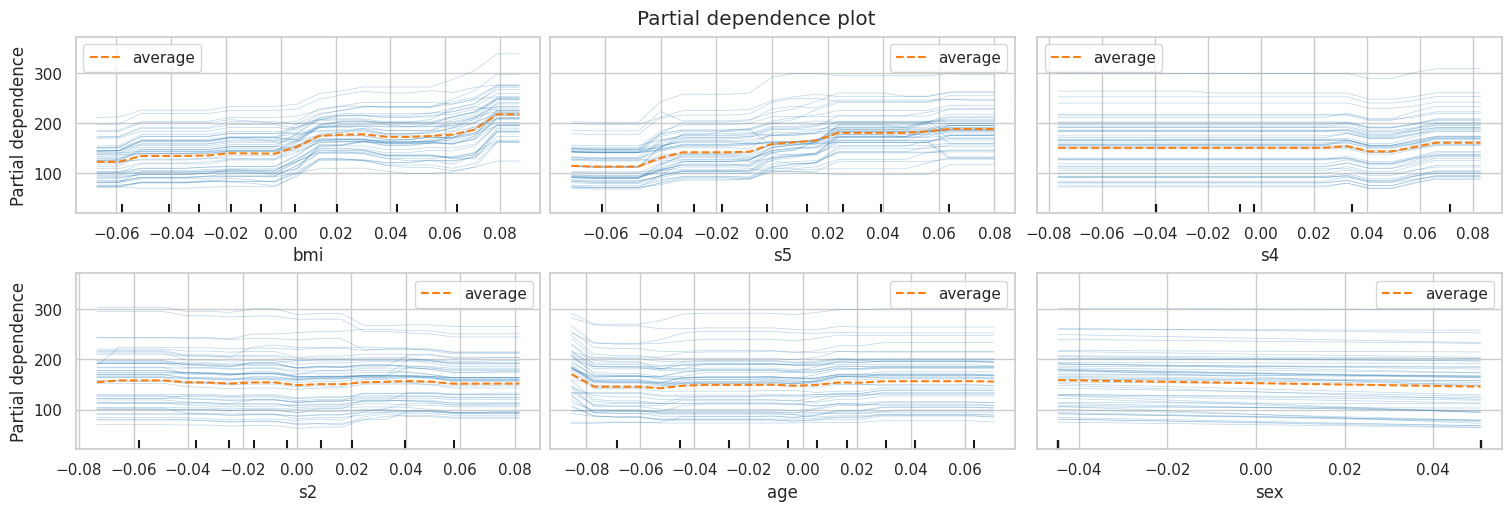

In [16]:
_,ax=plt.subplots(figsize=(15,5))
surrogate_explainer.partial_dependence_plot(ax=ax, kind="both") # kind: [individual,average,both]

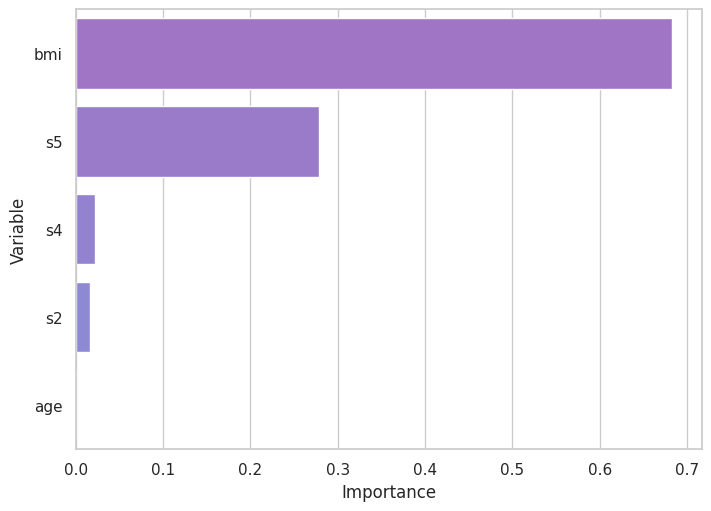

In [17]:
surrogate_explainer.bar_plot(max_display=5)

In [18]:
surrogate_explainer.feature_importance_table(sorted_by='Global', top_n=10)

,Global Importance
Variable,
bmi,0.682537
s5,0.278768
s4,0.022591
s2,0.016105
age,0.000000
sex,0.000000
bp,0.000000
s1,0.000000
s3,0.000000


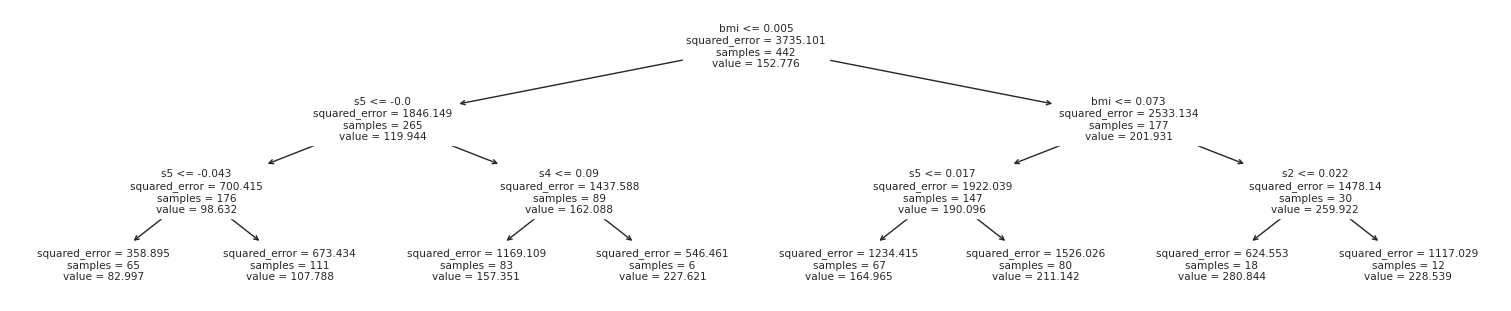

In [19]:
_,ax = plt.subplots(figsize=(15,3))
_ = surrogate_explainer.tree_visualization('sklearn', ax=ax)

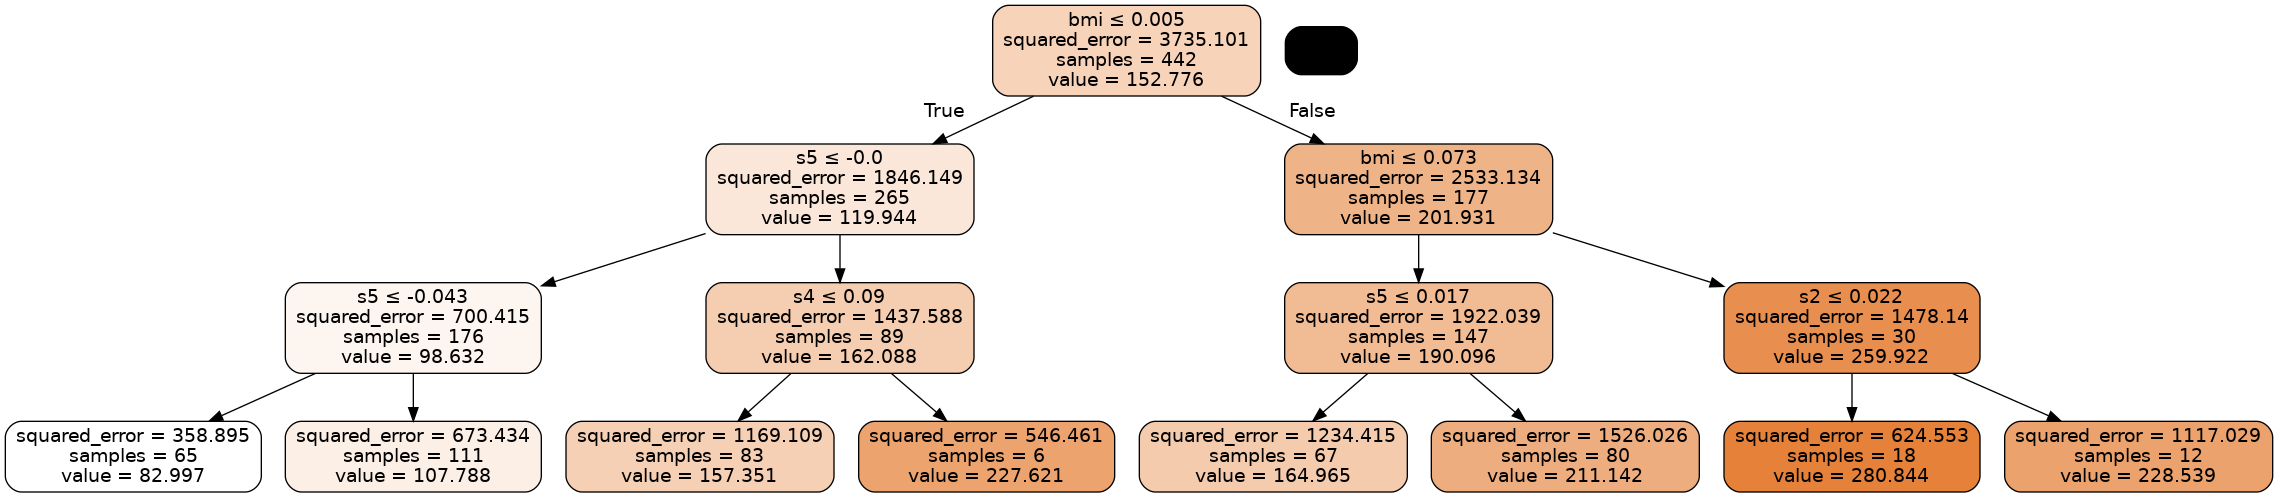

In [20]:
surrogate_explainer.tree_visualization('graphviz')

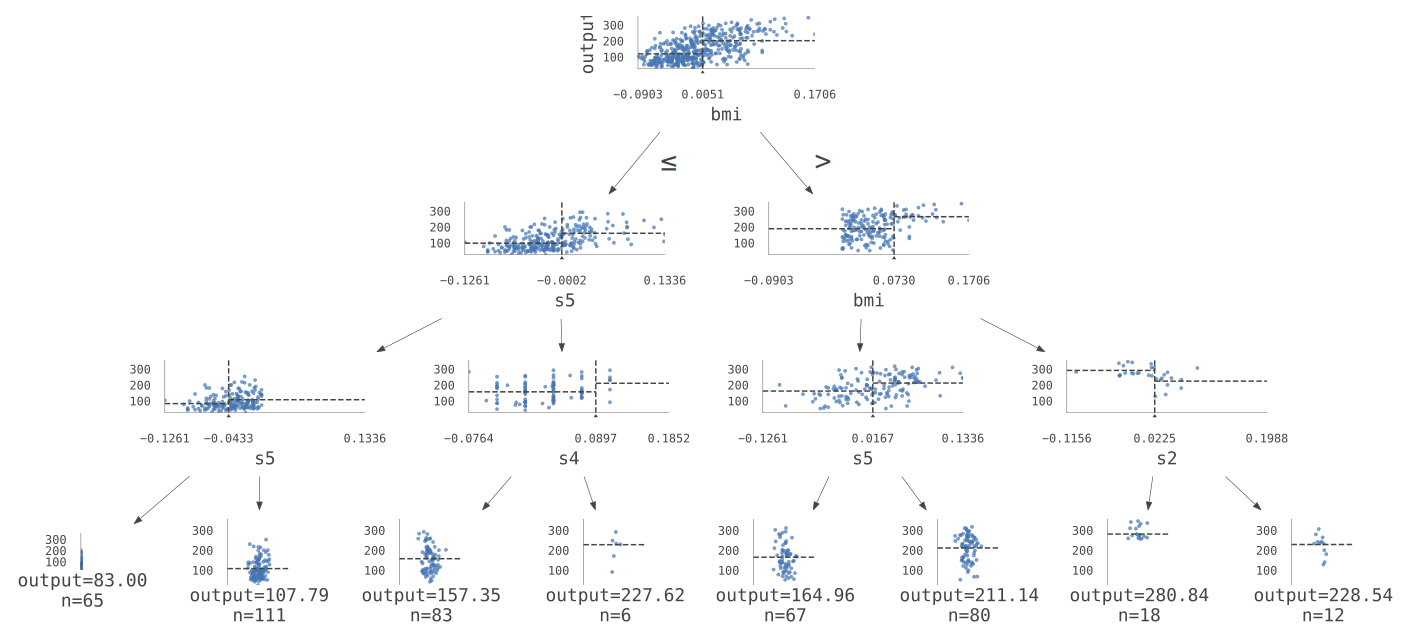

In [21]:
vis = surrogate_explainer.tree_visualization('dtreeviz', scale=2)
vis

# Local Explainability Metrics (based on Lime)

In [22]:
# lime feature importance
lime_explainer = Explainer(based_on='feature_importance',
                      strategy_type='lime',
                      model_type='regression',
                      model = model, 
                      x = X, 
                      y = y)

100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


In [23]:
lime_explainer.metrics(detailed=True)

,value,Reference
Metric,,
Dataset Stability Gini Global,0.041546,0
Dataset Stability Gini [Q0-Q1],0.039358,0
Dataset Stability Gini [Q1-Q2],0.038811,0
Dataset Stability Gini [Q2-Q3],0.042682,0
Dataset Stability Gini [Q3-Q4],0.043587,0
Dataset Stability Mean Global,0.837926,0
Dataset Stability Mean [Q0-Q1],0.837003,0
Dataset Stability Mean [Q1-Q2],0.841879,0
Dataset Stability Mean [Q2-Q3],0.845913,0


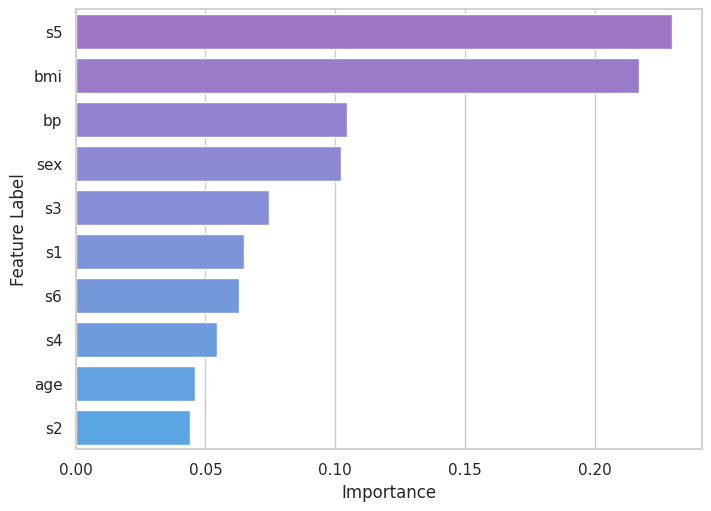

In [24]:
lime_explainer.bar_plot(max_display=10)

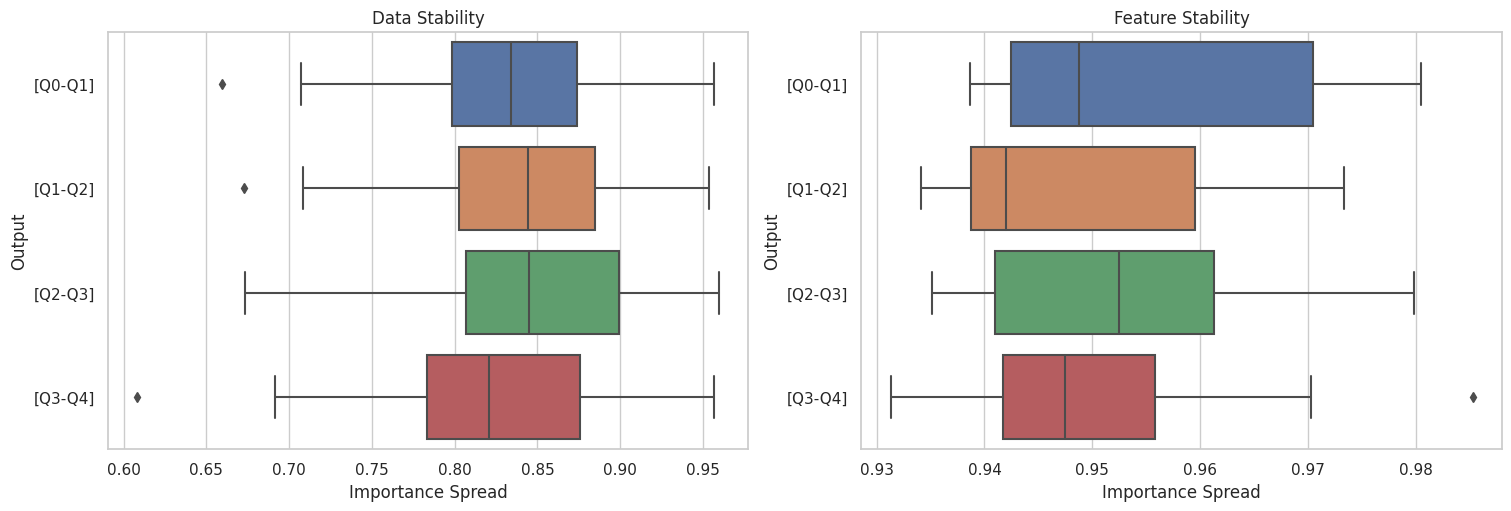

In [25]:
lime_explainer.show_importance_stability()

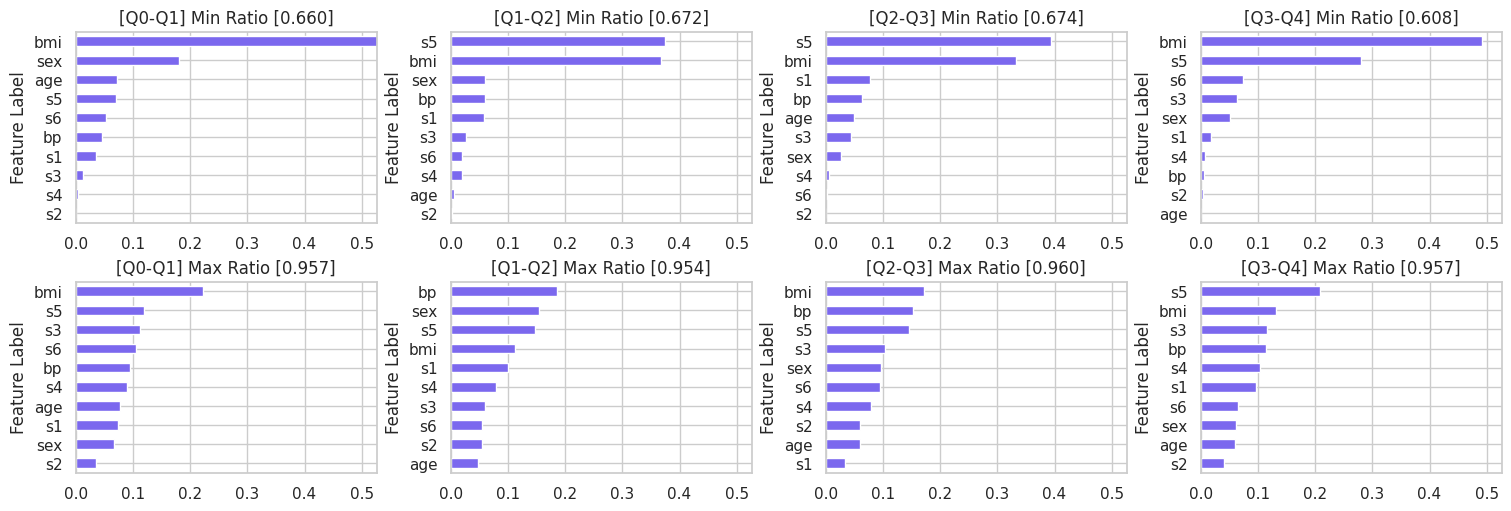

In [26]:
lime_explainer.show_data_stability_boundaries(top_n=10, figsize=(15,5))

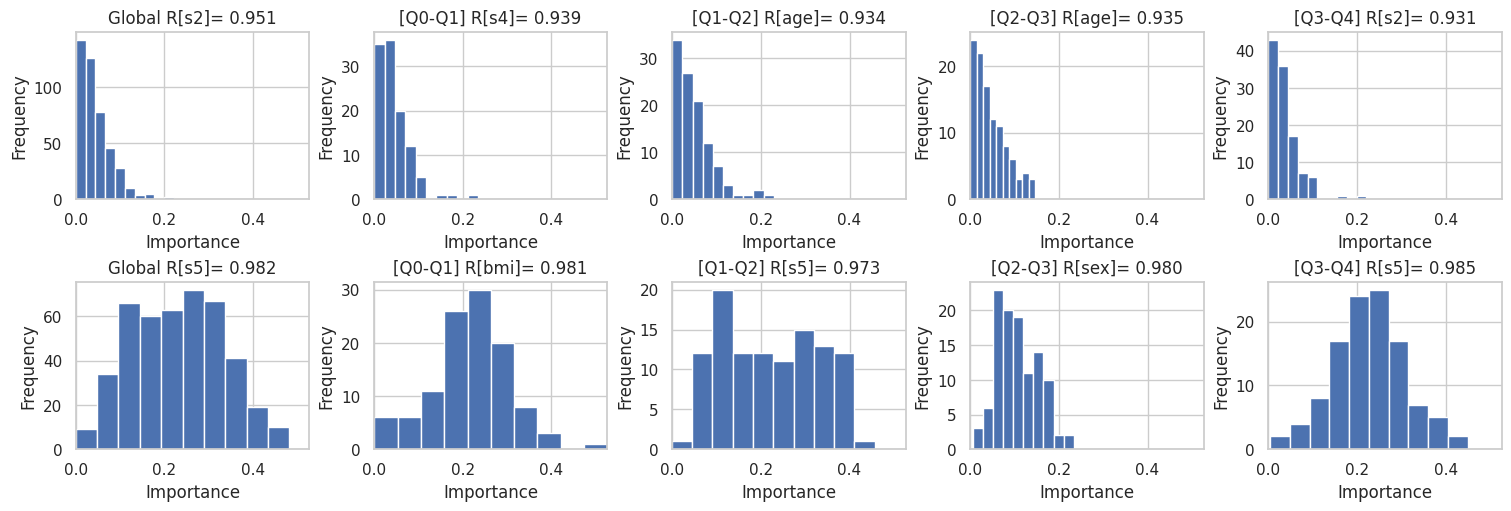

In [27]:
lime_explainer.show_features_stability_boundaries(figsize=(15,5))